<a href="https://colab.research.google.com/github/WannaGetDSJobInSanFrancisco/Machine_Notebooks/blob/main/TabNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U pytorch-tabnet

In [2]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)


import os
# import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

# Download census-income dataset

In [6]:
%mkdir data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data -O data/census-income.csv

--2022-05-22 16:19:20--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘data/census-income.csv’

data/census-income. 100%[===================>]   3.79M  16.4MB/s    in 0.2s    

2022-05-22 16:19:21 (16.4 MB/s) - ‘data/census-income.csv’ saved [3974305/3974305]



# Load data and split

In [7]:
out = "data/census-income.csv"

In [8]:
train = pd.read_csv(out)
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

# Simple preprocessing
- Label encode categorical features and fill empty cells.

In [9]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

39 73
 State-gov 9
 Bachelors 16
 13 16
 Never-married 7
 Adm-clerical 15
 Not-in-family 6
 White 5
 Male 2
 2174 119
 0 92
 40 94
 United-States 42
 <=50K 2
Set 3


In [10]:
# check that pipeline accepts strings
train.loc[train[target]==0, target] = "wealthy"
train.loc[train[target]==1, target] = "not_wealthy"

# Define categorical features for categorical embeddings

In [11]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

# Network parameters

In [32]:
tabnet_params = {"cat_idxs":cat_idxs,
                 "cat_dims":cat_dims,
                 "cat_emb_dim":1,
                 "optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax' # "sparsemax"
                }

clf = TabNetClassifier(**tabnet_params
                      )

Device used : cpu


# Training

In [19]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [20]:
max_epochs = 100 if not os.getenv("CI", False) else 2

In [26]:
# augmentations seems not included in PyPI version
# from pytorch_tabnet.augmentations import ClassificationSMOTE
# aug = ClassificationSMOTE(p=0.2)

In [33]:
# This illustrates the warm_start=False behaviour
save_history = []
for _ in range(2):
    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'],
        eval_metric=['auc'],
        max_epochs=max_epochs , patience=20,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False,
        #augmentations=aug, #aug, None
    )
    save_history.append(clf.history["valid_auc"])

# this assersion doesn't work - sure it won't, for it looks like save_history[idx] coressponds with # of valid_auc records (# of epochs) of target round 
# assert(np.all(np.array(save_history[0]==np.array(save_history[1]))))

epoch 0  | loss: 0.66821 | train_auc: 0.76144 | valid_auc: 0.75439 |  0:00:01s
epoch 1  | loss: 0.50938 | train_auc: 0.81146 | valid_auc: 0.81009 |  0:00:03s
epoch 2  | loss: 0.46689 | train_auc: 0.84758 | valid_auc: 0.84909 |  0:00:05s
epoch 3  | loss: 0.4519  | train_auc: 0.86998 | valid_auc: 0.86731 |  0:00:07s
epoch 4  | loss: 0.42997 | train_auc: 0.87727 | valid_auc: 0.87566 |  0:00:09s
epoch 5  | loss: 0.41893 | train_auc: 0.89268 | valid_auc: 0.88933 |  0:00:11s
epoch 6  | loss: 0.40284 | train_auc: 0.89904 | valid_auc: 0.89368 |  0:00:13s
epoch 7  | loss: 0.3934  | train_auc: 0.90191 | valid_auc: 0.89623 |  0:00:15s
epoch 8  | loss: 0.38517 | train_auc: 0.90667 | valid_auc: 0.90299 |  0:00:18s
epoch 9  | loss: 0.36761 | train_auc: 0.90933 | valid_auc: 0.90672 |  0:00:23s
epoch 10 | loss: 0.36991 | train_auc: 0.91036 | valid_auc: 0.9071  |  0:00:27s
epoch 11 | loss: 0.35489 | train_auc: 0.90695 | valid_auc: 0.90542 |  0:00:30s
epoch 12 | loss: 0.35914 | train_auc: 0.90745 | vali

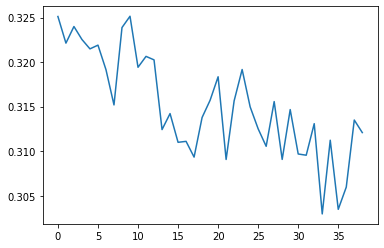

In [34]:
# plot losses
plt.plot(clf.history['loss'])

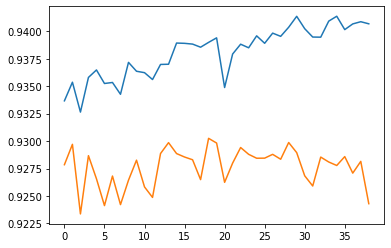

In [35]:
# plot auc
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['valid_auc'])

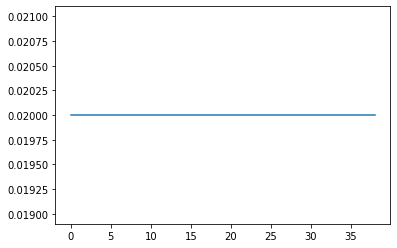

In [36]:
# plot learning rates
plt.plot(clf.history['lr'])

# Predictions

In [37]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)


preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")

BEST VALID SCORE FOR census-income : 0.9302527025040114
FINAL TEST SCORE FOR census-income : 0.9222911545714243


In [38]:
# check that best weights are used
assert np.isclose(valid_auc, np.max(clf.history['valid_auc']), atol=1e-6)

In [39]:
clf.predict(X_test)

array(['not_wealthy', 'not_wealthy', 'wealthy', ..., 'not_wealthy',
       'wealthy', 'wealthy'], dtype='<U11')

# Save and load Model

In [40]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [41]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

Device used : cpu
Device used : cpu


In [42]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score=loaded_preds[:,1], y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_auc}")

FINAL TEST SCORE FOR census-income : 0.9222911545714243


In [43]:
assert(test_auc == loaded_test_auc)

In [44]:
loaded_clf.predict(X_test)

array(['not_wealthy', 'not_wealthy', 'wealthy', ..., 'not_wealthy',
       'wealthy', 'wealthy'], dtype='<U11')

# Global explainability : feat importance summing to 1

In [45]:
clf.feature_importances_

array([0.05456593, 0.02463635, 0.00093314, 0.01862666, 0.13796164,
       0.12755866, 0.07219027, 0.13127836, 0.02950969, 0.0356125 ,
       0.15354651, 0.07262417, 0.06173228, 0.07922384])

# Local explainability and masks

In [46]:
explain_matrix, masks = clf.explain(X_test)

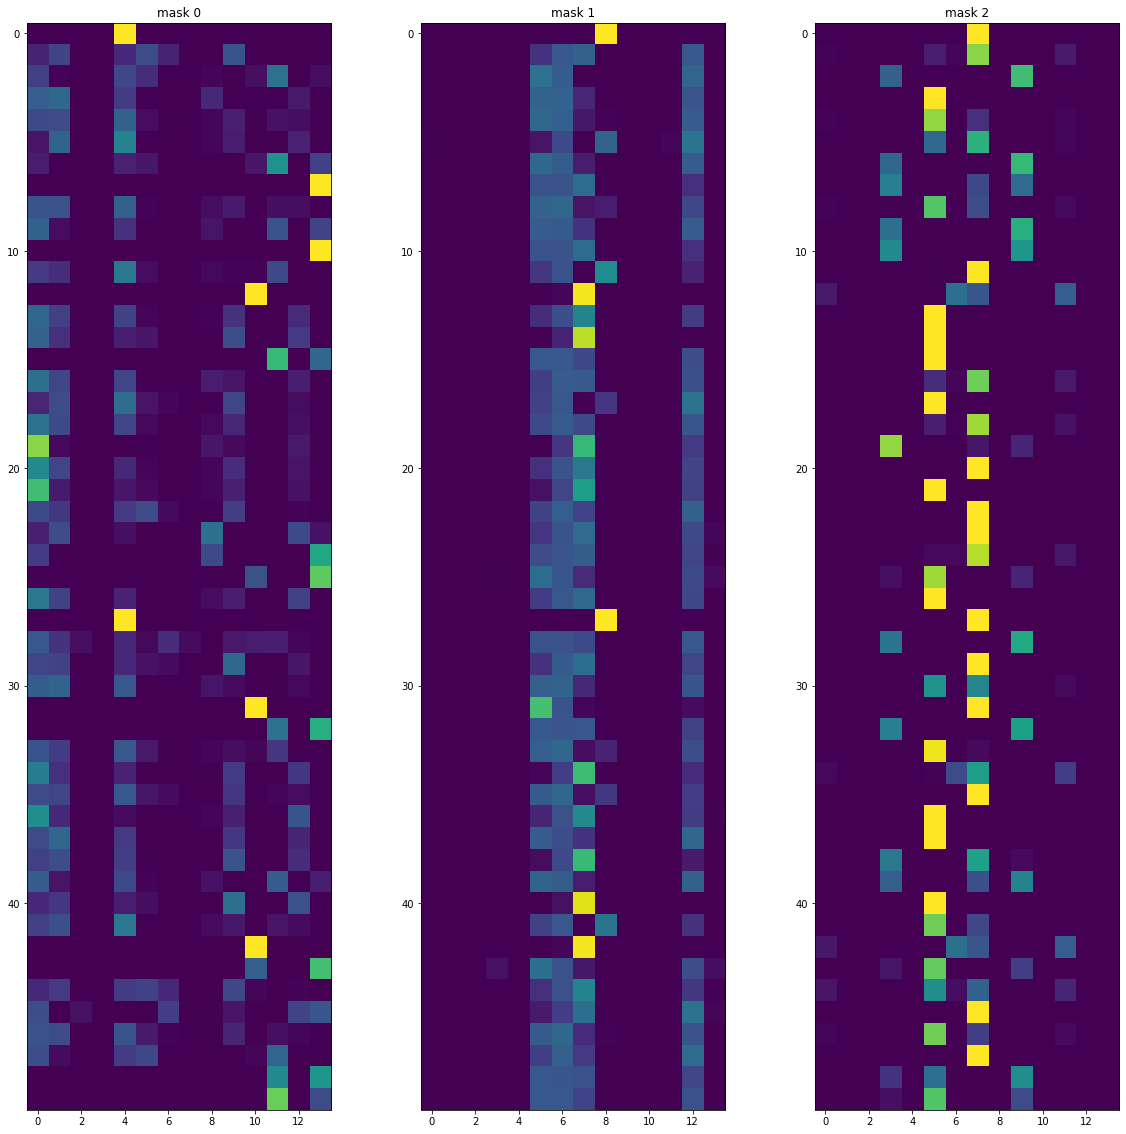

In [47]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")